# Plotting a Suite of Simulations

When we run a suite of simulations, such as when performing sensitivity tests or uncertainty propagation, it can be handy to plot that suite of runs together, and give the viewer a sense for how the uncertainty is manifest over the course of the simulation. 

### Libraries
In addition to the standard plotting, simulation and data handling libraries, we'll use the `seaborn` plotting library to handle density plots.

In [1]:
%pylab inline
import pysd
import numpy as np
import pandas as pd
import seaborn

Populating the interactive namespace from numpy and matplotlib


### Loading Model
The model we'll use in this example is a basic, 1-stock carbon bathtub model, in which `Emissions` contribute to a stock of `Excess Atmospheric Carbon`, which is slowly depleted through a process of `Natural Removal`.

![Atmospheric Bathtub](../../../source/models/Climate/Atmospheric_Bathtub.png).

In [2]:
model = pysd.read_vensim('../../models/Climate/Atmospheric_Bathtub.mdl')

### Creating a suite of run parameters
We'll generate a suite of simulations by drawing 1000 constant values for the `Emissions` parameter from an exponential distribution.

In [3]:
n_runs = 1000
runs = pd.DataFrame({'Emissions': np.random.exponential(scale=10000, size=n_runs)})
runs.head()

,Emissions
0,10619.175953
1,10854.493356
2,17405.296238
3,6649.127703
4,4454.821863


### Run the model with the various parameters
Next we'll run the model with our various values for emissions, and collect the resulting timeseries values of the stock of `Excess Atmospheric Carbon`.

The resulting dataframe `result` contains a column for each value simulation run, and these will form the traces for our plot.

In [4]:
result = runs.apply(lambda p: model.run(params=dict(p))['Excess Atmospheric Carbon'],
                    axis=1).T
result.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10619.175953,10854.493356,17405.296238,6649.127703,4454.821863,3560.003419,6640.764213,23972.691959,5816.878223,4160.733879,...,5354.787840,24506.090733,5391.310572,5042.198805,7717.170753,13855.131882,1254.482621,3288.548916,3995.330497,689.274481
2,21132.160146,21600.441778,34636.539514,13231.764129,8865.095508,7084.406803,13215.120785,47705.656999,11575.587665,8279.860420,...,10656.027801,48767.120558,10728.708037,10033.975622,15357.169798,27571.712446,2496.420415,6544.212344,7950.707690,1371.656217
3,31540.014497,32238.930716,51695.470357,19748.574190,13231.266416,10573.566154,19723.733790,71201.292388,17276.710011,12357.795695,...,15904.255362,72785.540086,16012.731529,14975.834671,22920.768853,41151.127204,3725.938832,9767.319137,11866.531110,2047.214135
4,41843.790305,42771.034765,68583.811892,26200.216151,17553.775615,14027.833911,26167.260665,94461.971424,22920.821135,16394.951618,...,21100.000648,96563.775418,21243.914785,19868.275130,30408.731918,54594.747814,4943.162064,12958.194862,15743.196296,2716.016475


### Draw a static plot showing the results, and a marginal density plot
The code below is what we might use for making a static graphic for publication in a print environment. The result is an image, and we have programmatic control over how we want the image displayed and saved. 

In the lefthand side of the plot, we draw all traces from the suite of simulation runs. Plotting each line in the same color, and setting a low value for `alpha`, the opacity of each line, we can see the regions of the plot in which a large number of simulations agree on the values the system will take, despite the parametric uncertainty.

In the righthand plot, we use a gaussian [Kernel Density Estimator](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) provided by the [seaborn](https://seaborn.pydata.org/index.html) library. The KDE gives an indication of the regions in which the density of simulation results is highest, at a specific time point in the simulation, which we refer to here as `density_time`. 

To indicate the simulation time for which we are displaying a density estimate, we'll add a vertical line at the point on the lefthand plot at which the density curve is calculated.

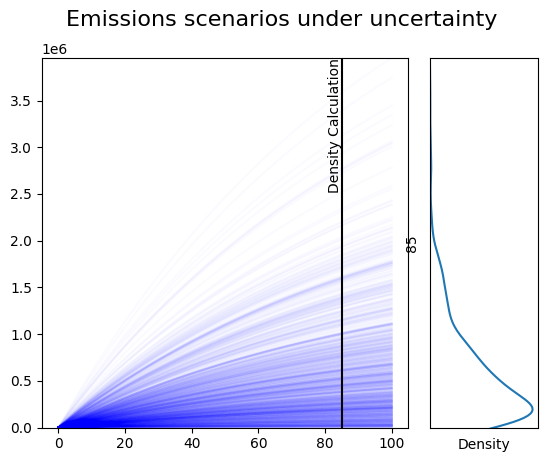

In [5]:
# define when to show the density
density_time = 85

# left side: plot all traces, slightly transparent
plt.subplot2grid((1,4), loc=(0,0), colspan=3)
[plt.plot(result.index, result[i], 'b', alpha=.02) for i in result.columns]
ymax = result.max().max()
plt.ylim(0, ymax)

# left side: add marker of density location
plt.vlines(density_time, 0, ymax, 'k')
plt.text(density_time, ymax, 'Density Calculation', ha='right', va='top', rotation=90)

# right side: gaussian KDE on selected timestamp
plt.subplot2grid((1,4), loc=(0,3))
seaborn.kdeplot(y=result.loc[density_time])
plt.ylim(0, ymax)
plt.yticks([])
plt.xticks([])
plt.xlabel('Density')

plt.suptitle('Emissions scenarios under uncertainty', fontsize=16);

### Static density plot with selector
For purposes of lightweight exploration, we can add a slider to the chart. In this case, whenever the slider is moved, the figure is regenerated, making this a suitable method for exploring results before feeding in to print graphics.

In [6]:
import matplotlib as mpl
from ipywidgets import interact, IntSlider
sim_time = 200
slider_time = IntSlider(description = 'Select Time for plotting Density',
                        min=0, max=result.index[-1], value=1)

In [7]:
@interact(density_time=slider_time)
def update(density_time): 
    ax1 = plt.subplot2grid((1,4), loc=(0,0), colspan=3)
    [ax1.plot(result.index, result[i], 'b', alpha=.02) for i in result.columns]
    ymax = result.max().max()
    ax1.set_ylim(0, ymax)

    # left side: add marker of density location
    ax1.vlines(density_time, 0, ymax, 'k')
    ax1.text(density_time, ymax, 'Density Calculation', ha='right', va='top', rotation=90)

    # right side: gaussian KDE on selected timestamp
    ax2 = plt.subplot2grid((1,4), loc=(0,3))
    seaborn.kdeplot(y=result.loc[density_time], ax=ax2)
    ax2.set_ylim(0, ymax)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel('Density')

    plt.suptitle('Emissions scenarios under uncertainty', fontsize=16);
    

interactive(children=(IntSlider(value=1, description='Select Time for plotting Density'), Output()), _dom_clas…